### snModel
Build a supernova light curve model and fit from a txt file.

In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
%matplotlib inline

import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.plots as plots

# open database use OpsimDatabase
opsdb = db.OpsimDatabase('baseline2018a.db')

# output
outDir = 'outdir'
resultsDb = db.ResultsDb(outDir=outDir)

### build a sn light curve model

#### Model with 3 parameters 

\begin{align}
L(t) &= \frac{E_{th}}{t_{sh}}(1-e^{-t/t_0}), \text{ for } t<t_{sh} \\
     &= \frac{E_{th}}{t_{sh}}e^{-t/t_0}(e^{t_{sh}/t_0}-1),  \text{ for } t>t_{sh}
\end{align}

In [2]:
from ipywidgets import interactive

# SN model
def snModel_3(t, tsh, Esh, t0):
    # use np.piecewise(x,condition list, function)

    condlist = [t < tsh, t >=tsh]
    
    func = [lambda t:Esh/tsh*(1-np.exp(-t/t0)), lambda t:Esh/tsh*np.exp(-t/t0)*(np.exp(tsh/t0)-1)]
      
    return np.piecewise(t, condlist, func)

def snLcplot(tsh,Esh,t0):
    t = np.arange(0,20,0.1)
    mags = snModel_3(t,tsh=tsh,Esh=Esh,t0=t0)
    plt.plot(t,mags)

interactive_plot = interactive(snLcplot, tsh=(0,18),Esh=(0,10),t0=(0.1,20))
interactive_plot


interactive(children=(IntSlider(value=9, description='tsh', max=18), IntSlider(value=5, description='Esh', max…

#### model with six parameters 

\begin{align}
f &= \frac{A+\beta (t-t0)}{1+e^{-(t-t_0)/\tau_{rise}}}, \text{ for } t<t_1\\
  &= \frac{(A+\beta(t_1-t_0))e^{-(t-t_1)/\tau_{fall}}}{1+e^{-(t-t_0)/\tau_{rise}}} \text{ for } t>t_1
\end{align}

In [3]:
def snModel_6(t, t1, A, t0, tau_rise, tau_fall, beta=0.1):
    condlist = [t < t1, t >= t1]
    
    func = [lambda t: (A + beta * (t - t0)) / (1 + np.exp(-(t - t0) / tau_rise)), 
            lambda t: (A + beta * (t1 - t0)) * 
            np.exp(-(t - t1) / tau_fall) / (1 + np.exp(-(t - t0) / tau_rise))]
      
    return np.piecewise(t, condlist, func)

def snLcplot(t1, A, t0, tau_rise, tau_fall, beta):
    t = np.arange(0,200,0.1)
    mags = snModel_6(t,t1=t1, A=A, t0=t0, tau_rise=tau_rise, tau_fall=tau_fall, beta=beta)
    plt.plot(t,mags)

interactive_plot = interactive(snLcplot, t1=(0,180), A=(0,10),t0=(0.1,200),tau_rise=(0.01,50), tau_fall=(0.1,200), beta=(-1,1,0.01))
interactive_plot



interactive(children=(IntSlider(value=90, description='t1', max=180), IntSlider(value=5, description='A', max=…

#### Polynomial model with 7 parameters

In [53]:
def snModel_pl(x, a, b, c, d, e, f, g):
    
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6

def snLcplot(a, b, c, d, e, f, g):
    t = np.arange(0,200,0.1)
    mags = snModel_pl(t, a, b, c, d, e, f, g)
    plt.plot(t,mags)

interactive_plot = interactive(snLcplot, a=(0,10),b=(0.,200),c=(0.0,50), d=(0.,200), e=(-1,1,0.01), f=(0,10), g=(0,1))
interactive_plot
    

interactive(children=(IntSlider(value=5, description='a', max=10), FloatSlider(value=100.0, description='b', m…

### Fit the sn model from txt file

In [49]:
pwd

'/home/docmaf/maf_local/maf'

In [175]:
# load light curve data
lc = np.genfromtxt('1998bw.txt', dtype=[('phase','f8'),('mag','f8'),('filter','S1')], delimiter=' ')

# decode byte to string
lcfilter=[]
for f in lc['filter']:
    lcfilter.append(f.decode('UTF-8'))
lcfilter = np.array(lcfilter) 
sortarray = np.argsort(lc['phase'])

# lc for a filter 'r'
fmatch = np.where(lcfilter[sortarray]=='r')
lcmagr = lc['mag'][sortarray][fmatch]

phaser = lc['phase'][sortarray][fmatch]



(24, 12)

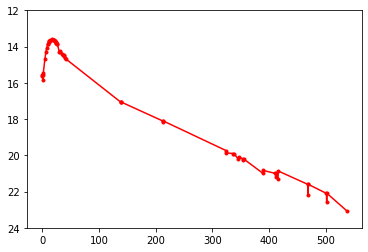

In [176]:
plt.plot(phaser,lcmagr,'r.-')
plt.ylim([24, 12])

In [7]:
# convert mag to flux
def mag2flux(m, m0):
    return 10**(-0.4 * (m - m0))
def flux2mag(fx, m0):
    return -2.5 * np.log10(fx) + m0

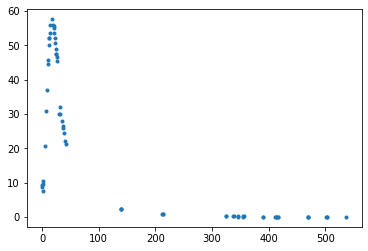

In [8]:
fluxr = mag2flux(lcmagr, 18)

plt.plot(phaser, fluxr, '.')

In [177]:
lcmagr

array([15.58, 15.65, 15.82, 15.54, 15.44, 14.71, 14.28, 14.08, 13.88,
       13.85, 13.75, 13.71, 13.71, 13.68, 13.63, 13.6 , 13.63, 13.64,
       13.65, 13.68, 13.71, 13.74, 13.78, 13.81, 13.81, 13.83, 13.86,
       14.31, 14.31, 14.24, 14.39, 14.44, 14.47, 14.53, 14.64, 14.68,
       17.06, 17.06, 17.06, 18.1 , 18.14, 18.1 , 19.74, 19.87, 19.9 ,
       19.9 , 20.21, 20.09, 20.2 , 20.27, 20.2 , 20.98, 20.83, 21.  ,
       21.18, 21.  , 21.32, 20.87, 21.6 , 22.21, 21.6 , 22.1 , 22.59,
       22.1 , 23.05])

In [178]:
flux2mag(fluxr, 18)

array([15.58, 15.65, 15.82, 15.54, 15.44, 14.71, 14.28, 14.08, 13.88,
       13.85, 13.75, 13.71, 13.71, 13.68, 13.63, 13.6 , 13.63, 13.64,
       13.65, 13.68, 13.71, 13.74, 13.78, 13.81, 13.81, 13.83, 13.86,
       14.31, 14.31, 14.24, 14.39, 14.44, 14.47, 14.53, 14.64, 14.68,
       17.06, 17.06, 17.06, 18.1 , 18.14, 18.1 , 19.74, 19.87, 19.9 ,
       19.9 , 20.21, 20.09, 20.2 , 20.27, 20.2 , 20.98, 20.83, 21.  ,
       21.18, 21.  , 21.32, 20.87, 21.6 , 22.21, 21.6 , 22.1 , 22.59,
       22.1 , 23.05])

#### fit 3-parameter model

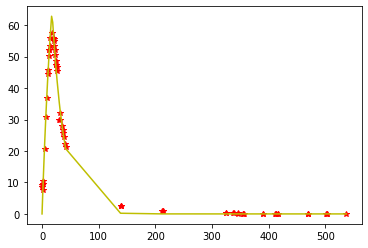

In [179]:
from scipy.optimize import curve_fit

xdat = phaser
ydat = fluxr
popt_3, pcov_3 = curve_fit(snModel_3, xdat, ydat)

yfit_3 = snModel_3(xdat, *popt_3)
plt.plot(xdat, ydat, 'r*', xdat, yfit_3,'y-')

#### fit 6-parameter model

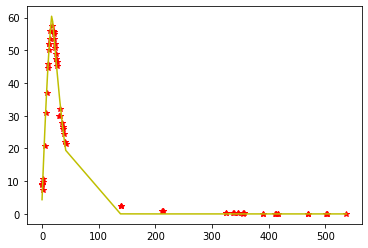

In [180]:
xdat = phaser
ydat = fluxr
popt_6, pcov_6 = curve_fit(snModel_6, xdat, ydat)

yfit_6 = snModel_6(xdat,*popt_6)
plt.plot(xdat, ydat, 'r*', xdat, yfit_6,'y-')

#### fit polynomial model

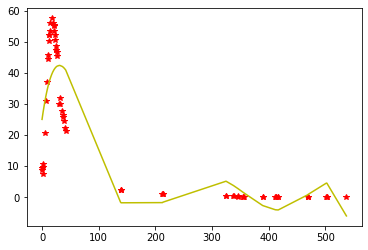

In [181]:
xdat = phaser
ydat = fluxr
popt_pl, pcov_pl = curve_fit(snModel_pl, xdat, ydat)

yfit_pl = snModel_pl(xdat, *popt_pl)
plt.plot(xdat, ydat, 'r*', xdat, yfit_pl,'y-')


In [182]:
popt_3

array([  17.57681555, 2019.05611777,   21.28678818])

In [183]:
popt_6

array([ 17.48186617, 134.50562305,  23.33953006, -14.11948424,
       214.45169464,   5.54074993])

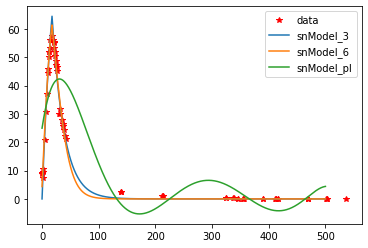

In [184]:
x = np.arange(0, 500, .1)
y3 = snModel_3(x, *popt_3)
y6 = snModel_6(x, *popt_6)
ypl = snModel_pl(x, *popt_pl)
plt.plot(phaser, fluxr, 'r*' ,x, y3, x, y6, x, ypl)
plt.legend(['data', 'snModel_3', 'snModel_6', 'snModel_pl'])

## likelihood ratio test

likelihood for Gaussian distribution

\begin{align}
L = (2 \pi \sigma^2)^{-n/2} e^{-\frac{1}{2\sigma^2}\sum(x_j - \mu)^2 }
\end{align}

log-likelihood function
\begin{align}
logL = -\frac{n}{2} ln(2\pi) - \frac{n}{2}ln(\sigma^2) - \frac{1}{2\sigma^2}\sum (x_j - \mu)^2 
\end{align}



likelihood ratio test

\begin{align}
R_L = \frac{L_0}{L_1} \\
\chi^2 = -2 ln(R_L) = -2 (ln L_0 - ln L_1) = \frac{1}{\sigma^2} \sum_0 (x_j - \mu)^2 - \frac{1}{\sigma^2} \sum_1 (x_j - \mu)^2
\end{align}

The decision rule 
- If $\chi^2 > c$, do not reject H_0. 
- If $\chi^2 < c$, reject H_0.

significance level $\alpha$
\begin{align}
P( \chi^2 < c) = \alpha
\end{align}

In [18]:
from scipy.stats import chi2


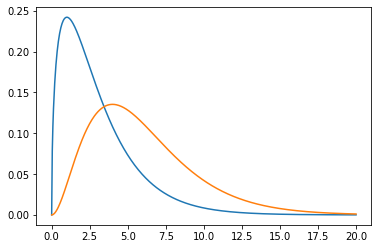

In [308]:
x = np.linspace(0, 20, 500)

y3 = chi2.pdf(x, 3)   # chi square degree of freedom 3
y6 = chi2.pdf(x, 6)

plt.plot(x, y3, x, y6)

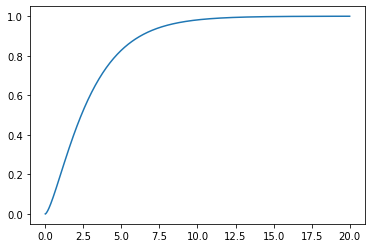

In [25]:
y = chi2.cdf(x, 3)
plt.plot(x, y, '-')

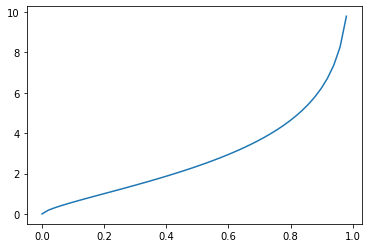

In [144]:
x = np.linspace(0,1)
y = chi2.ppf(x,3)
plt.plot(x, y, '-')

In [300]:
def logL(ydat, yfit):
    error = ydat - yfit
    sigma2 = np.std(error)**2
    
    return np.sum( (ydat - yfit)**2 / sigma2)


In [301]:
logL_3 = logL(ydat, yfit_3)/
logL_6 = logL(ydat, yfit_6)
logL_pl = logL(ydat, yfit_pl)
logL_3, logL_6, logL_pl

(68.18690189772323, 65.73707338911596, 65.00000000000051)

goodness of fit for a model

In [306]:
logL_3/(65 - 3), logL_6/(65 - 6), logL_pl/(65 - 7)

(1.0997887402858586, 1.1141876845612875, 1.1206896551724226)

In [302]:
ratio = logL_3 - logL_6

ratio

2.4498285086072684

In [299]:
chi2.ppf(0.95, 3)

7.814727903251179

 snModel_6 is better, reject snModel_3

### fit type IIp light curve

In [250]:
# load light curve data
lc_IIp = np.genfromtxt('lc_IIp.txt', dtype=[('phase','f8'),('mag','f8'),('filter','S1')], delimiter=' ')

# decode byte to string
lcfilter=[]
for f in lc_IIp['filter']:
    lcfilter.append(f.decode('UTF-8'))
lcfilter = np.array(lcfilter) 
sortarray = np.argsort(lc_IIp['phase'])

# lc for a filter 'r'
fmatch = np.where(lcfilter[sortarray]=='r')
lcmagr_IIp = lc_IIp['mag'][sortarray][fmatch]

phaser_IIp = lc_IIp['phase'][sortarray][fmatch]


(22, 17)

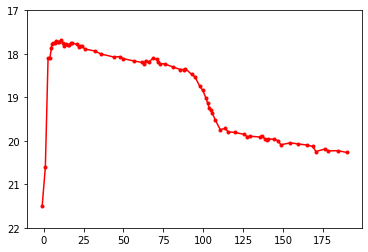

In [254]:
plt.plot(phaser_IIp, lcmagr_IIp, 'r.-')
plt.ylim([22, 17])

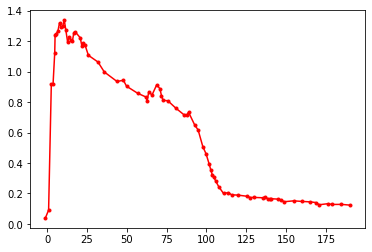

In [255]:
fluxr_IIp = mag2flux(lcmagr_IIp, 18)

plt.plot(phaser_IIp, fluxr_IIp, 'r.-')

#### fit model 3

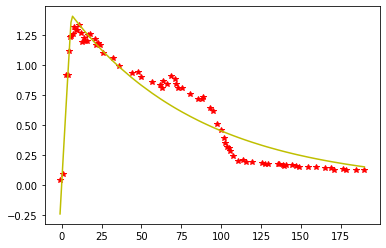

In [256]:
xdat_IIp = phaser_IIp
ydat_IIp = fluxr_IIp
popt_3_IIp, pcov_3_IIp = curve_fit(snModel_3, xdat_IIp, ydat_IIp)

yfit_3_IIp = snModel_3(xdat_IIp, *popt_3_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*', xdat_IIp, yfit_3_IIp,'y-')

#### fit model 6

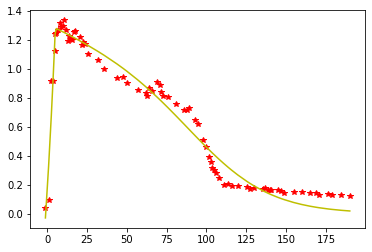

In [258]:
popt_6_IIp, pcov_6_IIp = curve_fit(snModel_6, xdat_IIp, ydat_IIp, maxfev=3000)

yfit_6_IIp = snModel_6(xdat_IIp,*popt_6_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*', xdat_IIp, yfit_6_IIp,'y-')

#### fit polynomial

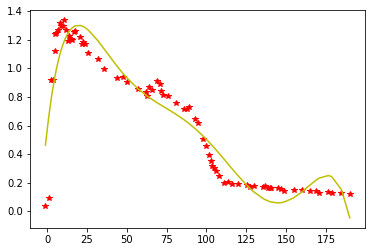

In [259]:
popt_pl_IIp, pcov_pl_IIp = curve_fit(snModel_pl, xdat_IIp, ydat_IIp)

yfit_pl_IIp = snModel_pl(xdat_IIp, *popt_pl_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*', xdat_IIp, yfit_pl_IIp,'y-')


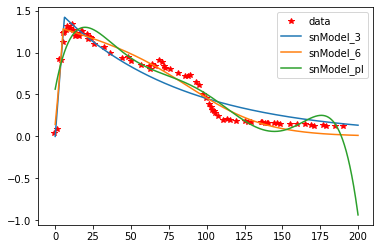

In [260]:
x = np.arange(0, 200, .1)
y3 = snModel_3(x, *popt_3_IIp)
y6 = snModel_6(x, *popt_6_IIp)
ypl = snModel_pl(x, *popt_pl_IIp)
plt.plot(xdat_IIp, ydat_IIp, 'r*' ,x, y3, x, y6, x, ypl)
plt.legend(['data', 'snModel_3', 'snModel_6', 'snModel_pl'])


### likelihood ratio test

In [262]:
logL_3_IIp = logL(ydat_IIp, yfit_3_IIp)
logL_6_IIp = logL(ydat_IIp, yfit_6_IIp)
logL_pl_IIp = logL(ydat_IIp, yfit_pl_IIp)
logL_3_IIp, logL_6_IIp, logL_pl_IIp

(77.14782985602979, 77.8824465189271, 77.00000000000101)

In [280]:
ratio_IIp = logL_3_IIp - logL_pl_IIp
ratio_IIp

0.1478298560287783

In [281]:
chi2.ppf(0.95, 4)

9.487729036781154

In [307]:
logL_3_IIp/(65 - 3), logL_6_IIp/(65 - 6), logL_pl_IIp/(65 - 7)

(1.2443198363875771, 1.320041466422493, 1.3275862068965691)

model3 and model 6 are similar, can't use likelihood ratio

snModel_6 is better

##### model comparison 

In [133]:
def AIC(logL, N, k):
    return logL + 2*k + (2 * k * (k+1) ) / (N - k - 1)

def BIC(logL, N, k):
    return logL + k * np.log(N)

In [132]:
aic_3 = AIC(logL_3, 65, 3)
aic_6 = AIC(logL_6, 65, 6)
aic_pl = AIC(logL_pl, 65, 7)
aic_3, aic_6, aic_pl

(74.58034452067405, 79.18534925118493, 80.96491228070226)

In [134]:
bic_3 = BIC(logL_3, 65, 3)
bic_6 = BIC(logL_6, 65, 6)
bic_pl = BIC(logL_pl, 65, 7)
bic_3, bic_6, bic_pl

(80.71006370741014, 90.78339700848979, 94.22071088926997)

better to choose model3